In [14]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import random

In [16]:
def generate_noise_patch(pixels_per_degree=27, size_deg=15, mean_lum=28, std_lum=4.375):
    """
    Generates a Gaussian white noise patch.
    
    Parameters:
    - pixels_per_degree: screen resolution scaling
    - size_deg: size of image in degrees
    - mean_lum: mean luminance (cd/m^2)
    - std_lum: standard deviation of luminance
    
    Returns:
    - noise_patch: 2D numpy array
    """
    size_px = int(size_deg * pixels_per_degree)
    noise_patch = np.random.normal(mean_lum, std_lum, (size_px, size_px))
    return noise_patch

def generate_signal_blob(pixels_per_degree=27, size_deg=15, blob_std_deg=0.5, contrast=0.02, mean_lum=28):
    """
    Generates a Gaussian blob signal to embed into noise.
    
    Parameters:
    - blob_std_deg: standard deviation of Gaussian blob in degrees
    - contrast: signal contrast (e.g. 0.02 for 2%)
    - mean_lum: mean luminance
    
    Returns:
    - blob: 2D numpy array (same size as stimulus)
    """
    size_px = int(size_deg * pixels_per_degree)
    blob_std_px = blob_std_deg * pixels_per_degree
    
    x = np.linspace(-size_px//2, size_px//2, size_px)
    y = np.linspace(-size_px//2, size_px//2, size_px)
    X, Y = np.meshgrid(x, y)
    
    gaussian = np.exp(-(X**2 + Y**2) / (2 * blob_std_px**2))
    
    # Normalize to peak contrast then scale by mean luminance
    blob = gaussian * contrast * mean_lum
    return blob

def create_stimulus(signal_present, contrast, save_path, trial_num, condition):
    """
    Creates and saves an individual stimulus image.
    
    Parameters:
    - signal_present: bool
    - contrast: float
    - save_path: directory to save image
    - trial_num: trial index
    - condition: condition name for file naming
    """
    noise = generate_noise_patch()
    if signal_present:
        blob = generate_signal_blob(contrast=contrast)
        stimulus = noise + blob
    else:
        stimulus = noise
    
    # Clip to valid display range (0-255) for saving as image
    stimulus_clipped = np.clip(stimulus, 0, 255)
    stimulus_image = Image.fromarray(stimulus_clipped.astype(np.uint8))
    
    # Save
    label = 'present' if signal_present else 'absent'
    filename = f"{condition}_{label}_trial{trial_num:04d}.png"

    stimulus_image.save(os.path.join(save_path, filename))

def generate_stimuli_batch(n_trials, signal_prob, contrasts, save_dir, condition_name):
    """
    Generates a batch of stimuli for a condition.
    
    Parameters:
    - n_trials: number of trials
    - signal_prob: probability of signal-present trials
    - contrasts: dict with keys for 'signal_present' and 'signal_absent'
    - save_dir: base directory
    - condition_name: string to name files
    """
    os.makedirs(save_dir, exist_ok=True)
    
    for i in range(n_trials):
        signal_present = np.random.rand() < signal_prob
        contrast = contrasts['signal_present'] if signal_present else 0.0
        create_stimulus(signal_present, contrast, save_dir, i, condition_name)

In [17]:
if __name__ == "__main__":
    # Example usage
    np.random.seed(42)  # For reproducibility
    
    # Parameters from the study
    trials_per_condition = 200
    signal_probability = 0.5
    
    # Equal strength condition
    equal_strength_contrasts = {'signal_present': 0.02, 'signal_absent': 0.0}
    generate_stimuli_batch(trials_per_condition, signal_probability, equal_strength_contrasts, "equal_strength_images", "equal")
    
    # Mixture condition (example with weak signal 0.005 and strong signal 0.09, handled per participant later)
    mixture_contrasts = {'signal_present': 0.005, 'signal_absent': 0.0}
    generate_stimuli_batch(trials_per_condition, signal_probability, mixture_contrasts, "mixture_images", "mixture_weak")
    
    # For strong signal trials, rerun with contrast=0.09 for the participant receiving strong signal
    mixture_strong_contrasts = {'signal_present': 0.09, 'signal_absent': 0.0}
    generate_stimuli_batch(trials_per_condition, signal_probability, mixture_strong_contrasts, "mixture_images", "mixture_strong")
    
    print("Stimuli generation complete.")

Stimuli generation complete.


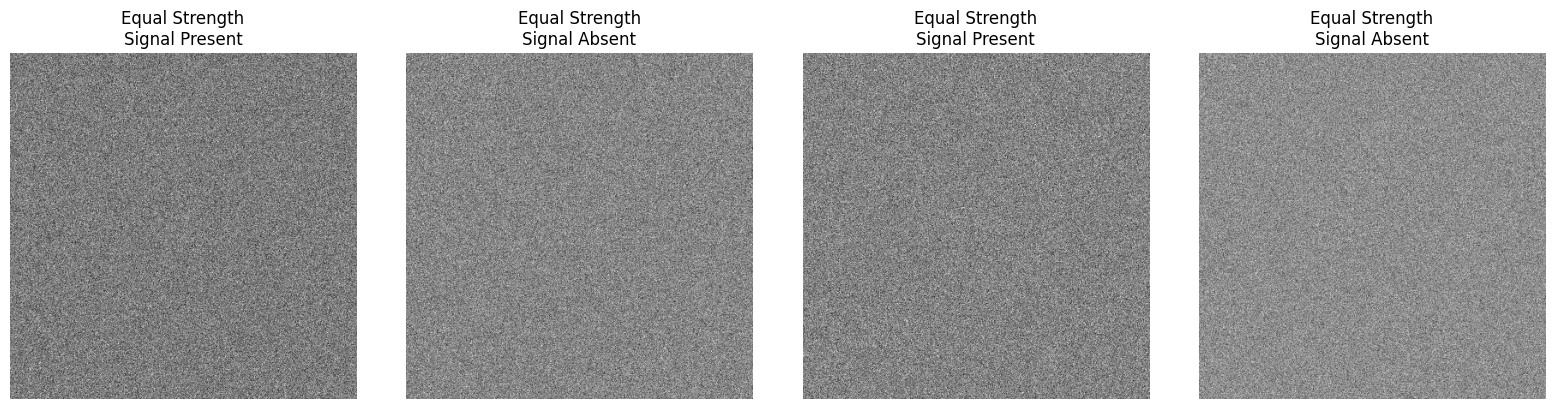

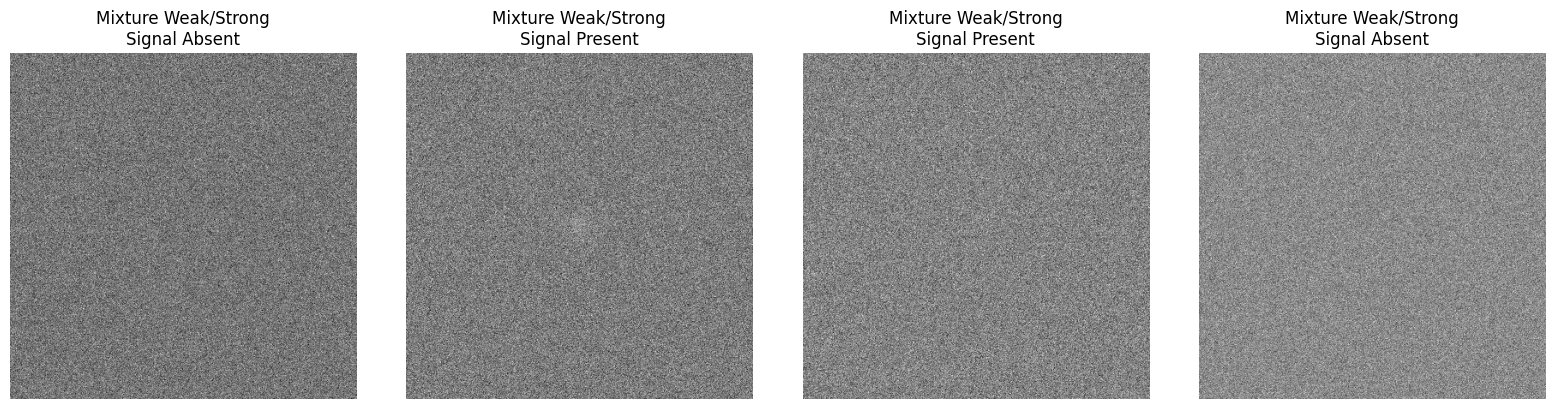

In [18]:
def show_balanced_samples(directory, n_present=2, n_absent=2, condition_name=""):
    """
    Displays n_present and n_absent images from the specified directory.
    
    Parameters:
    - directory: path to images folder
    - n_present: number of signal-present images to display
    - n_absent: number of signal-absent images to display
    - condition_name: title for the plot
    """
    files = [f for f in os.listdir(directory) if f.endswith('.png')]
    
    # Separate present and absent based on filename
    present_files = [f for f in files if 'present' in f.lower()]
    absent_files = [f for f in files if 'absent' in f.lower()]
    
    # Randomly sample requested number, without replacement
    sampled_present = random.sample(present_files, min(n_present, len(present_files)))
    sampled_absent = random.sample(absent_files, min(n_absent, len(absent_files)))
    
    # Combine and shuffle to randomize order in display
    all_samples = sampled_present + sampled_absent
    random.shuffle(all_samples)
    
    # Plot
    total = len(all_samples)
    plt.figure(figsize=(4*total, 4))
    
    for i, file_name in enumerate(all_samples):
        img = Image.open(os.path.join(directory, file_name))
        
        # Label from filename
        label = "Signal Present" if 'present' in file_name.lower() else "Signal Absent"
        
        plt.subplot(1, total, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{condition_name}\n{label}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Example usage after generation
    show_balanced_samples("equal_strength_images", n_present=2, n_absent=2, condition_name="Equal Strength")
    show_balanced_samples("mixture_images", n_present=2, n_absent=2, condition_name="Mixture Weak/Strong")